In [1]:
%matplotlib inline
import os
import numpy as np
import esmlab

import intake
import intake_esm
import ncar_jobqueue
from dask.distributed import Client

import utils
import climo_utils as cu
import ann_avg_utils as aau
units, _ = aau.get_pint_units()

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

numpy         1.17.3
intake_esm    2019.12.13
ncar_jobqueue 2019.10.16.1
intake        0.5.3
esmlab        2019.4.27
Mike Levy 2020-02-12 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper21
Git hash   : eb0ba4e268d2ef6d7ccbce7716e44476a3100fca


In [2]:
cluster = ncar_jobqueue.NCARCluster(project='P93300606')
cluster.adapt(minimum_jobs=0, maximum_jobs=24)
client = Client(cluster)
client

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://128.117.181.227:43305 Dashboard: https://jupyterhub.ucar.edu/dav/user/mlevy/proxy/32848/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
nutrients = ['NO3', 'PO4', 'SiO3']
three_ocean_regions = True

In [4]:
%%time

catalog = intake.open_esm_datastore('/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/campaign-cesm2-cmip6-timeseries.json')

da_surf = dict()
ds = dict()
da_surf_obs = dict()
ds_obs = dict()

for variable in nutrients:
    # Read CESM and WOA data
    dq = catalog.search(experiment='historical', component='ocn', variable=variable).to_dataset_dict(cdf_kwargs={'chunks':{'time': 4}})
    ds[variable] = cu.read_CESM_var(dq, slice("1990-01-15", "2015-01-15"), variable) # 1990 - 2014, inclusive
    ds_obs[variable] = cu.read_obs(src='WOA', variable=variable)

    da_tmp = ds[variable][variable]
    da_surf[variable] = (da_tmp.isel(z_t=0).data * units[ds[variable][variable].attrs['units']])
    da_tmp = ds_obs[variable][variable]
    da_surf_obs[variable]=da_tmp.isel(z_t=0).data * units[da_tmp.attrs['units']] * (1026*units['kg/m^3'])

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'
             
--> There are 1 group(s)
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'
             
--> There are 1 group(s)
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'
             
--> There are 1 group(s)
CPU times: user 32.6 s, sys: 8.66 s, total: 41.3 s
Wall time: 4min 24s


In [5]:
%%time
kwargs = {'grid' : 'gx1v7'}
if three_ocean_regions:
    kwargs['rmask_file'] = os.path.join(os.path.sep,
                                        'glade',
                                        'p',
                                        'cgd',
                                        'oce',
                                        'people',
                                        'klindsay',
                                        'oldcgdoce',
                                        'REGION_MASK',
                                        'new_REGION_MASK_gx1v6.nc')

da_zonal_mean = dict()
da_zonal_mean_obs = dict()
for var in nutrients:
    ds_tmp = utils.zonal_mean_via_fortran(ds[var], var, **kwargs)
    da_zonal_mean[var] = ds_tmp[var]
    ds_tmp = utils.zonal_mean_via_fortran(ds_obs[var], var, **kwargs)
    da_zonal_mean_obs[var] = ds_tmp[var]

za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
CPU times: user 640 ms, sys: 742 ms, total: 1.38 s
Wall time: 4.78 s


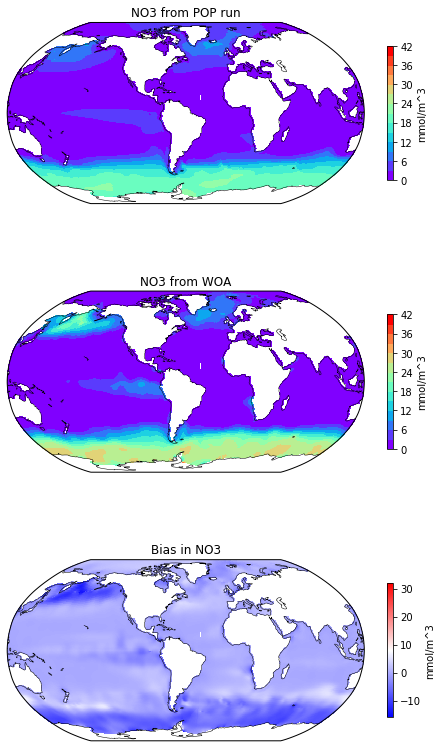

In [6]:
cu.plot_surface_vals('NO3', ds, da_surf, da_surf_obs, obs_src='WOA', force_units='mmol/m^3')

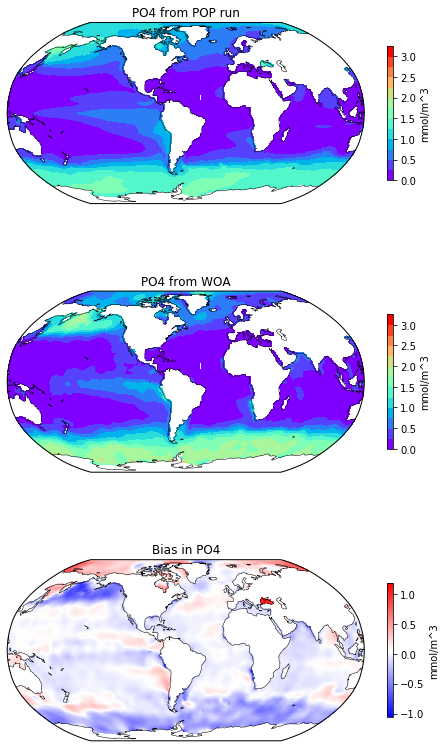

In [7]:
cu.plot_surface_vals('PO4', ds, da_surf, da_surf_obs, obs_src='WOA', force_units='mmol/m^3')

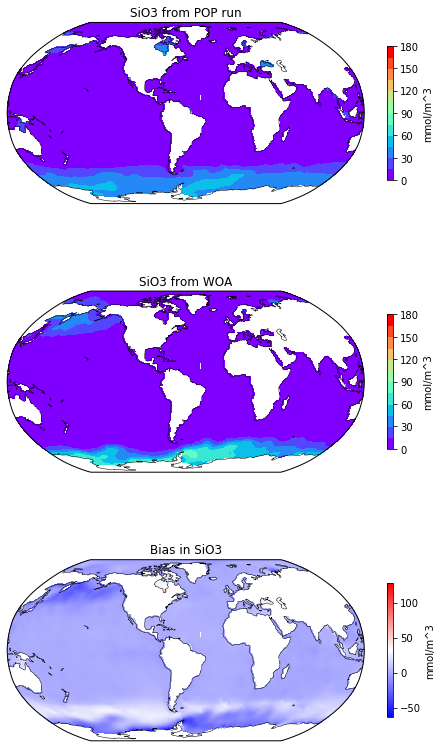

In [8]:
cu.plot_surface_vals('SiO3', ds, da_surf, da_surf_obs, obs_src='WOA', force_units='mmol/m^3')

## Compute global profile

Here we use `esmlab` to average over lat / lon, but leave depth

In [9]:
%%time

glb_avg = dict()
glb_avg_obs = dict()

for variable in nutrients:
    print(f'Computing weighted mean of {variable} for CESM output...')
    da_tmp = esmlab.weighted_mean(ds[variable][variable], weights=ds[variable].TAREA, dim=['nlat', 'nlon']).compute()
    glb_avg[variable] = (da_tmp.data * units[ds[variable][variable].attrs['units']])

    print(f'Computing weighted mean of {variable} for WOA data...')
    da_tmp = esmlab.weighted_mean(ds_obs[variable][variable], weights=ds_obs[variable].TAREA, dim=['nlat', 'nlon']).compute()
    glb_avg_obs[variable] = ((da_tmp.data * units[ds_obs[variable][variable].attrs['units']]) * (1026*units['kg/m^3'])).to('mmol/m^3')


Computing weighted mean of NO3 for CESM output...
Computing weighted mean of NO3 for WOA data...
Computing weighted mean of PO4 for CESM output...
Computing weighted mean of PO4 for WOA data...
Computing weighted mean of SiO3 for CESM output...
Computing weighted mean of SiO3 for WOA data...
CPU times: user 870 ms, sys: 2.19 s, total: 3.06 s
Wall time: 3.86 s


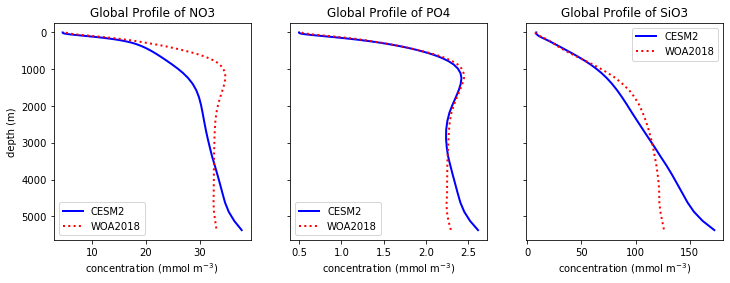

In [10]:
cu.plot_global_profile(nutrients, units, ds, glb_avg, glb_avg_obs)

## Regional Plots

Regions based on code in POP repository:

```
$ cat input_templates/gx1v7_region_ids
   1  'Southern Ocean    '        0.0   0.0      0.0
   2  'Pacific Ocean     '        0.0   0.0      0.0
   3  'Indian Ocean      '        0.0   0.0      0.0
   4  'Persian Gulf      '       22.0  60.0      0.0
  -5  'Red Sea           '       14.0  47.0      3.0e15
   6  'Atlantic Ocean    '        0.0   0.0      0.0
   7  'Mediterranean Sea '       36.0 354.0      0.0
   8  'Labrador Sea      '        0.0   0.0      0.0
   9  'GIN Sea           '        0.0   0.0      0.0
  10  'Arctic Ocean      '        0.0   0.0      0.0
  11  'Hudson Bay        '       61.0 295.0      0.0
 -12  'Baltic Sea        '       56.0   8.0      3.0e15
 -13  'Black Sea         '       40.0  25.0      3.0e15
```

Unless running with `three_ocean_regions = True`, in which case the regions are

```
   1  'Pacific Ocean'
   2  'Indian Ocean'
   3  'Atlantic Ocean'
```

(Not documented anywhere handed, but seen in `/glade/p/cgd/oce/people/klindsay/oldcgdoce/REGION_MASK/new_rmask.m`

```
REGION_MASK(find(REGION_MASK == 2)) = 1;
REGION_MASK(find(REGION_MASK == 3)) = 2;
REGION_MASK(find(REGION_MASK == 6)) = 3;
```

In [11]:
# In Keith's zon_avg tool, region is indexed by basin_id
# basin_id=0 => global
# basin_id = |region_id| => region (from table above)

regions = dict()
regions['Global'] = 0
if three_ocean_regions:
    regions['Pacific Ocean'] = 1
    regions['Indian Ocean'] = 2
    regions['Atlantic Ocean'] = 3
else:
    regions['Southern Ocean'] = 1
    regions['Pacific Ocean'] = 2
    regions['Indian Ocean'] = 3
    regions['Atlantic Ocean'] = 6

da_regional = dict()
da_regional_obs = dict()
for region in regions:
    da_regional[region] = dict()
    da_regional_obs[region] = dict()
    for variable in nutrients:
        # Note that we store a pint object to track units at this stage
        da_regional[region][variable] = da_zonal_mean[variable].isel(basins=regions[region]).data * units[da_zonal_mean[var].attrs['units']]
        da_regional_obs[region][variable] = da_zonal_mean_obs[variable].isel(basins=regions[region]).data * units[da_zonal_mean_obs[var].attrs['units']] * (1026*units['kg/m^3'])

In [12]:
for var_tmp in nutrients:
    cesm = cu.return_magnitude_in_units(da_regional['Global'][var_tmp], 'mmol/m^3')
    woa = cu.return_magnitude_in_units(da_regional_obs['Global'][var_tmp], 'mmol/m^3')
    bias = cesm - woa
    print(f'{var_tmp}\n----')
    print(f'CESM range: {np.nanmin(cesm)}, {np.nanmax(cesm)}')
    print(f'WOA range: {np.nanmin(woa)}, {np.nanmax(woa)}')
    print(f'Bias max: {np.nanmax(np.abs(bias))}\n')

NO3
----
CESM range: 0.19587558507919312, 47.7788200378418
WOA range: 0.22430771589279175, 40.13529968261719
Bias max: 19.122671127319336

PO4
----
CESM range: 0.10860081017017365, 3.4720852375030518
WOA range: 0.10823500156402588, 3.0283310413360596
Bias max: 0.8206684589385986

SiO3
----
CESM range: 1.992660403251648, 265.53570556640625
WOA range: 1.771030068397522, 223.22459411621094
Bias max: 79.23678588867188



In [13]:
lat = da_zonal_mean[nutrients[0]].lat_t.data
z = da_zonal_mean[nutrients[0]].z_t.data

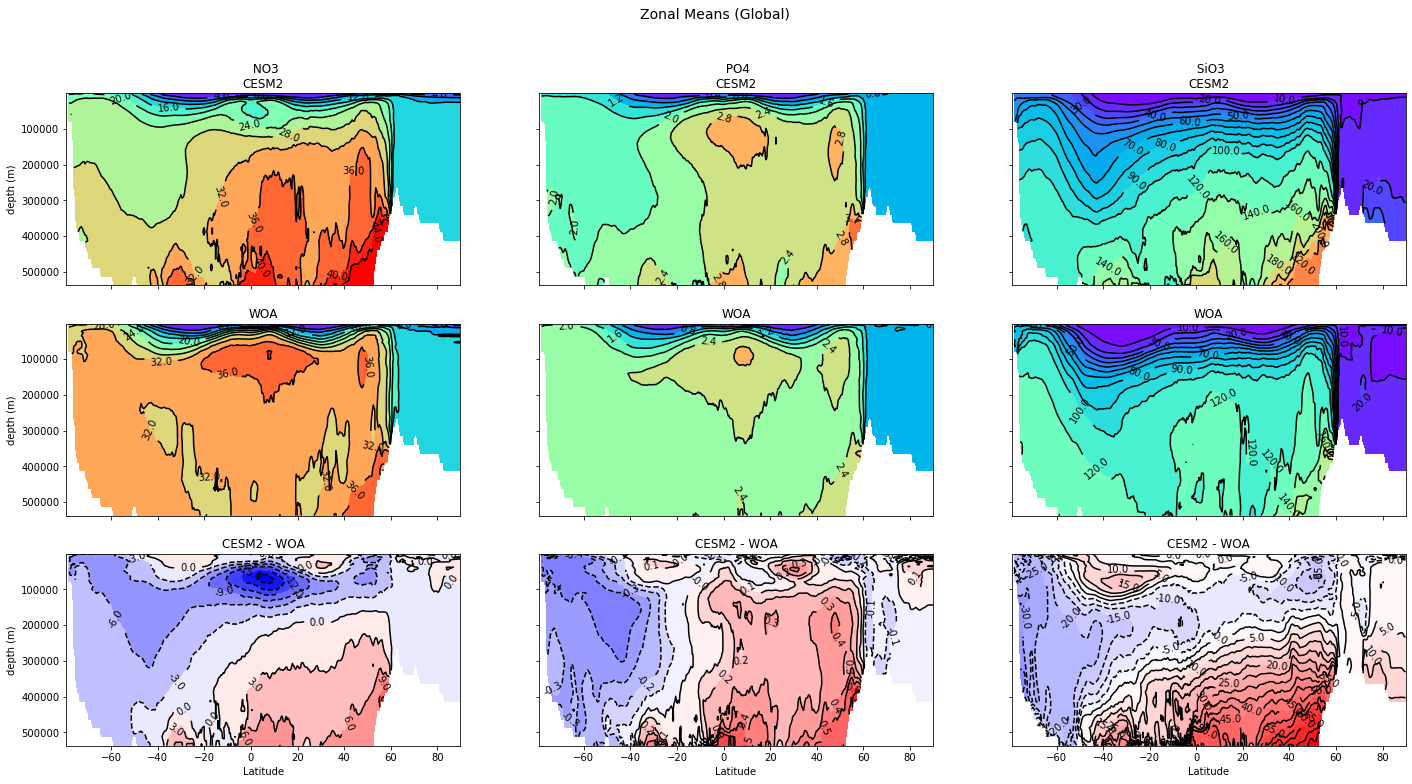

In [14]:
cu.plot_zonal_averages_by_region(nutrients, 'Global', da_regional, da_regional_obs, lat, z)

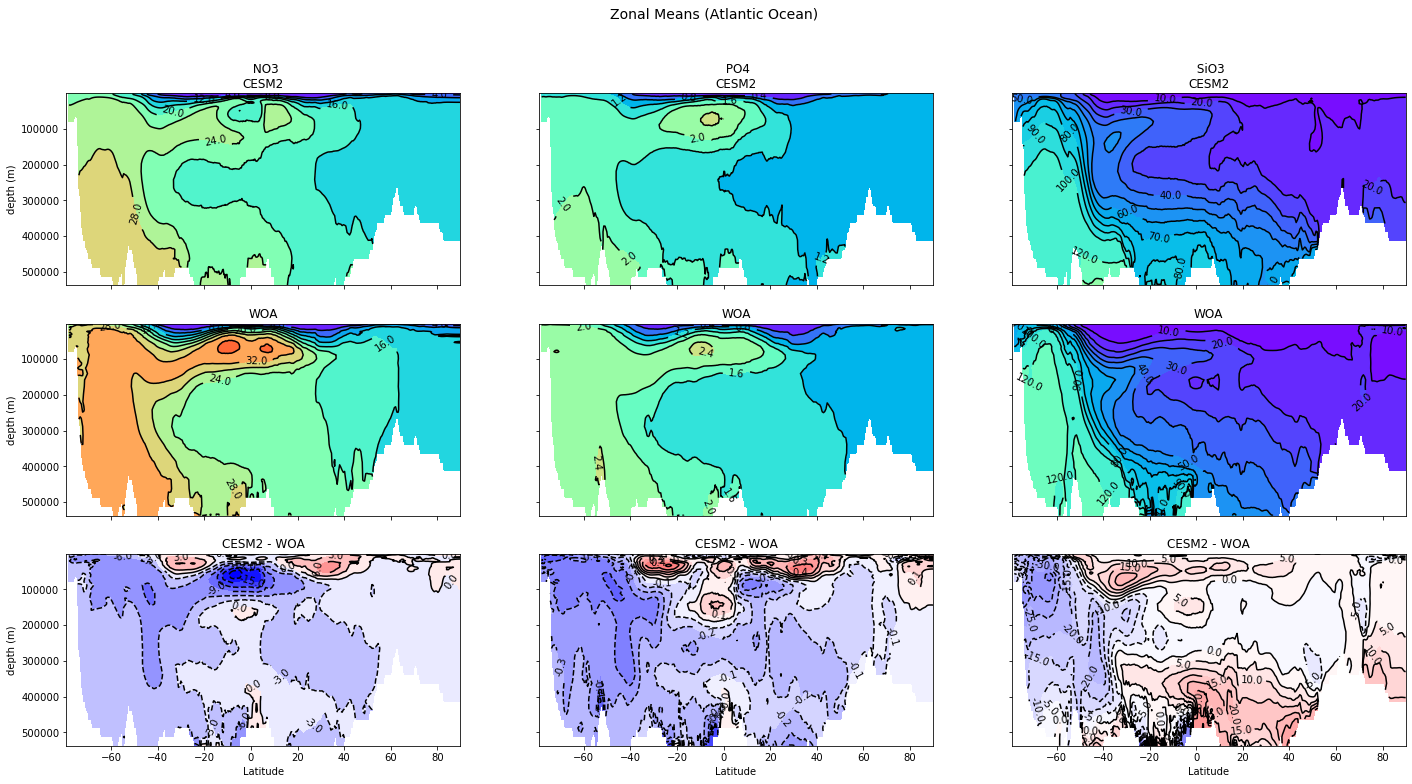

In [15]:
cu.plot_zonal_averages_by_region(nutrients, 'Atlantic Ocean', da_regional, da_regional_obs, lat, z)

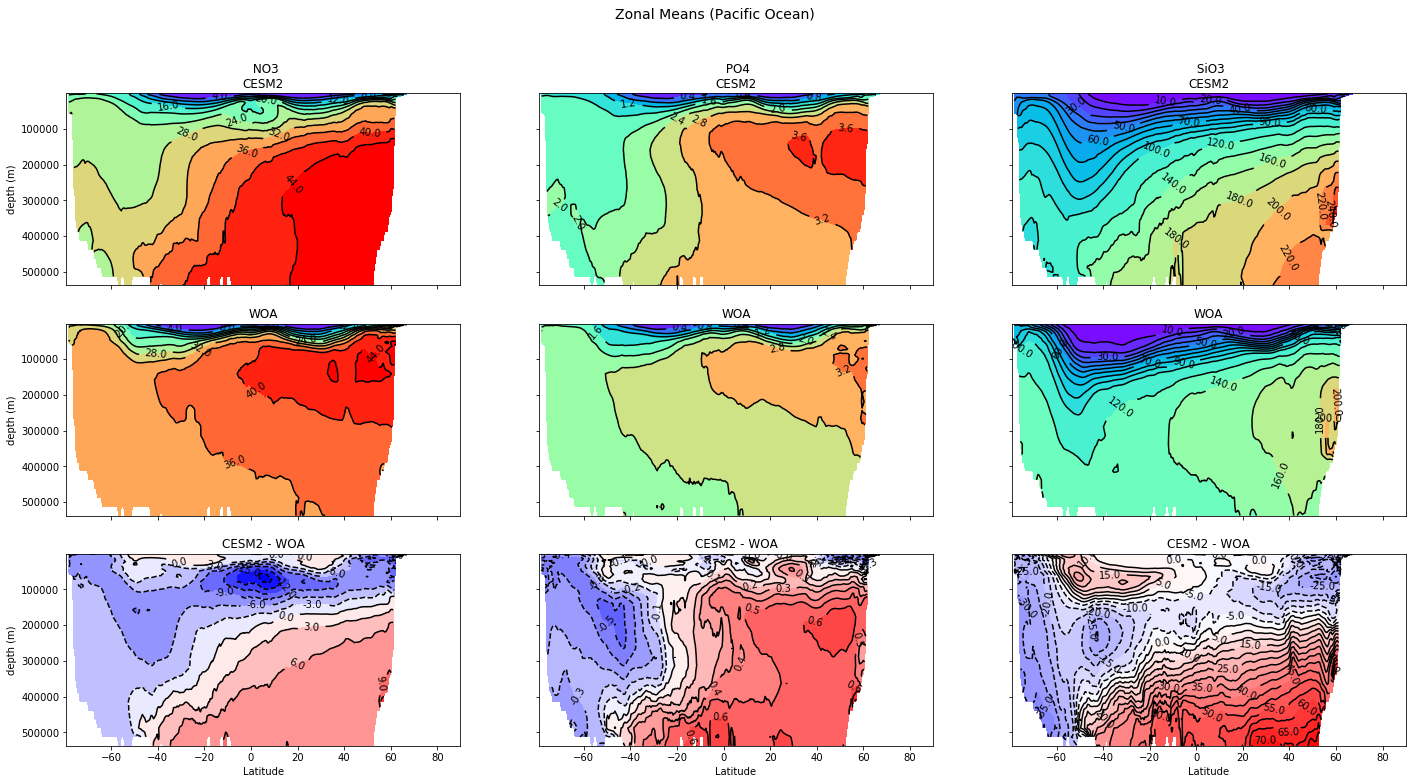

In [16]:
cu.plot_zonal_averages_by_region(nutrients, 'Pacific Ocean', da_regional, da_regional_obs, lat, z)

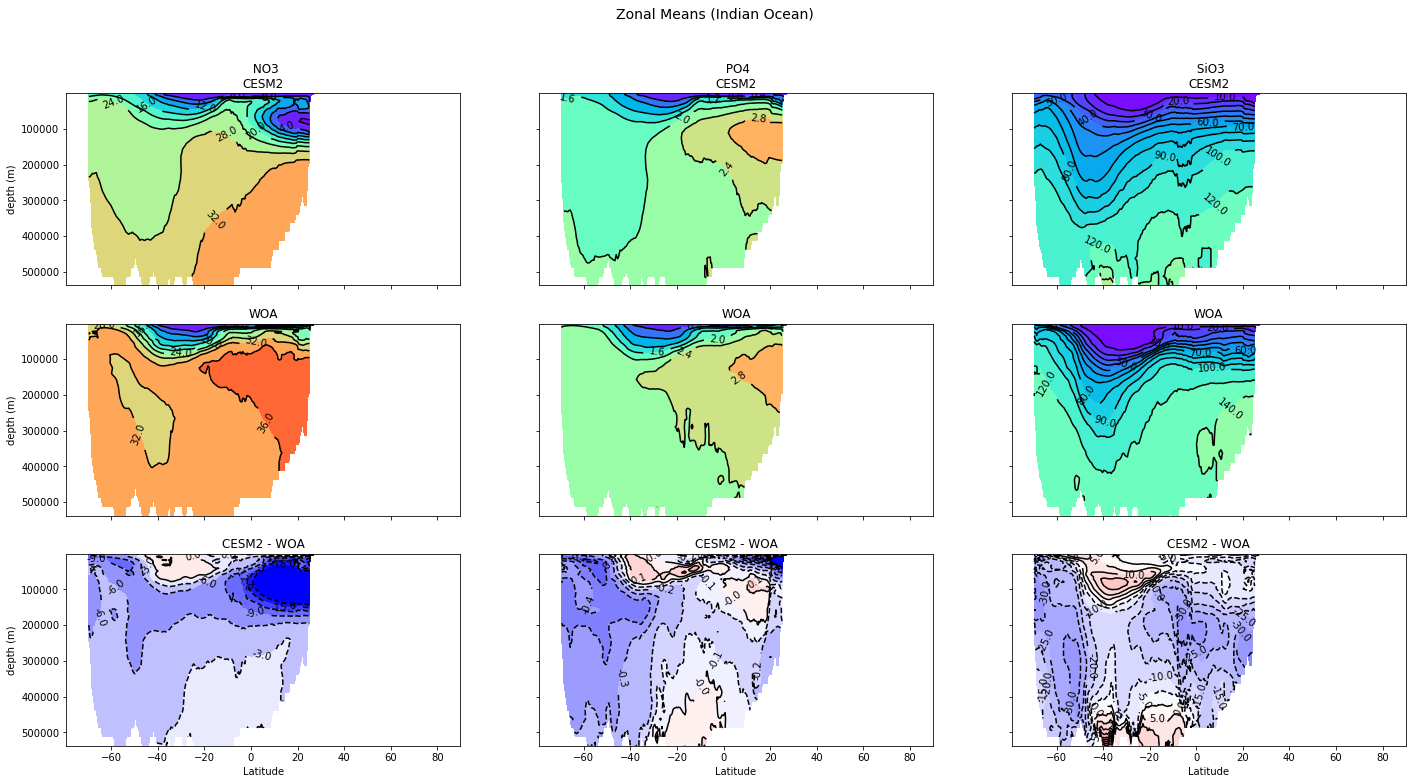

In [17]:
cu.plot_zonal_averages_by_region(nutrients, 'Indian Ocean', da_regional, da_regional_obs, lat, z)